---
format: 
  html:
    toc: true
execute:
  echo: true
---

# Looking at Environmental Rasters

Despite Kathmandu's natural and historic beauty, the city in recent years has seen a rapid decline in living conditions. Haphazard sprawl, mismanaged public transport, rapid loss of green space, and climate change have been affecting the liveability of the city [1](https://fukuoka.unhabitat.org/wp-content/uploads/2021/12/Kathmandu_ValleyNepalMarch2015.pdf). While everyone acknowledges this problem, there is still a lack of quantified research into this topic, especially from an urban planning perspective. This is an issue for the city that contains 24% of the country's urban population, and contributes to 33% of the country's GDP [2](https://www.kvda.gov.np/uploads/form/SDMP%20part1.pdf). With agricultural and forested land increasingly being decimated to accomodate this sprawl, the valley is facing an environmental crisis that routinely puts it as the most polluted city in the world [3](https://kathmandupost.com/climate-environment/2024/04/10/kathmandu-world-s-most-polluted-city-again).

I seek to examine these trends, especially as they relate to loss of greenery and urban heat islands in this section of the report. Using satellite data from Landsat 8, I seek to calculate the NDVI (Normalized Difference Vegetation Index), a measure for greenergy, as well as the Land Surface Temperature (LST), a measure for temperature, for the city between the years 2013 and 2023. Using the insights gathered from this extraction, I seek to identify the regions of the city that perform worse on these indexes. 

## Getting Landsat Data with Earth Engine

To begin my analysis, I first download and extract my required files from the Google Earth Engine API. I will first call an earth engine object that contains composite, cloud cover minimized values for the years 2013 and 2023. Then, using the valley and city boundaries extracted in part 1 of my analysis, I will limit these shapefiles to the boundaries of my study_area and perform the analysis.

In [4]:
#setting up GEE
import ee
ee.Authenticate()
ee.Initialize()

In [5]:
import geopandas as gpd
#calling valley geometry 
valley = gpd.read_file("../data/sfs/valley.geojson")
#creating an earth engine object of the boundary 
ee_geometry = ee.Geometry(valley.__geo_interface__['features'][0]['geometry'])

I have already created my composite, saved it to my google drive, and downloaded it locally on my repository. The code section below details my approach. For my analysis, I will begin by calling in my locally saved files in the next section.

In [100]:
# setting up my start and end dates for two years
start_date_2013 = '2013-01-01'
start_date_2023 = '2023-01-01'
end_date_2013 = '2013-12-31'
end_date_2023 = '2023-12-31'

#creating yearly composite
comp_2013 =  ee.ImageCollection('LANDSAT/LC08/C02/T1_L2').filterBounds(ee_geometry).filterDate(start_date_2013, end_date_2013).filter(ee.Filter.lt('CLOUD_COVER', 20)).median()
comp_2023 = ee.ImageCollection('LANDSAT/LC08/C02/T1_L2')\
    .filterBounds(ee_geometry)\
    .filterDate(start_date_2023, end_date_2023)\
    .filter(ee.Filter.lt('CLOUD_COVER', 20))\
    .median()



#Creating tasks to extract it from Earth engine to my local google drive
task_2013 = ee.batch.Export.image.toDrive(
    image=comp_2013,
    description='landsat_13',
    scale=30, 
    region=ee_geometry,
    maxPixels=1e9,
    fileFormat='GeoTIFF'
)

# Export 2023 composite
task_2023 = ee.batch.Export.image.toDrive(
    image=comp_2023,
    description='landsat_23',
    scale=30,
    region=ee_geometry,
    maxPixels=1e9,
    fileFormat='GeoTIFF'
)

#starting tasks
task_2013.start()
task_2023.start()

## Calculating NDVI and LST
I have the data already loaded to my local system, so I will start by loading it in. I will also mask my rasters to the extent of my study area. After loading the data, two key environmental measures will be extracted—NDVI, which measures the amount of greenery, and LST values of the extent. 

NDVI is calculated using Landsat's Near-Infrared (Band 5) and Red (Band 4) bands, following the formula: NDVI = (NIR - Red)/(NIR + Red), where NIR is Band 5 and Red is Band 4. This index ranges from -1 to 1, with higher values indicating denser vegetation. 

In [6]:
import rasterio as rio
from shapely.geometry import box
from rasterio.mask import mask
import numpy as np

#calling my rasters
landsat13 = rio.open("../data/landsat/landsat_13.tif")
landsat23 = rio.open("../data/landsat/landsat_23.tif")

#calling my city file
main_city = gpd.read_file('../data/sfs/maincity.geojson')


study_masked13, study_transform13 = mask(
    dataset=landsat13,              
    shapes=main_city.geometry,  
    crop=True,                    
    all_touched=True,            
    filled=False,                 
)

study_masked23, study_transform23 = mask(
    dataset=landsat23,              
    shapes=main_city.geometry,  
    crop=True,                    
    all_touched=True,            
    filled=False,                 
)

#getting the needed layers
red13 = study_masked13[4]
nir13 = study_masked13[5]
red23 = study_masked23[4]
nir23= study_masked23[5]

#calculating NDVI
def calculate_NDVI(nir, red):
    """
    Calculate the NDVI from the NIR and red landsat bands
    """

    # Convert to floats
    nir = nir.astype(float)
    red = red.astype(float)

    # Get valid entries
    check = np.logical_and(red.mask == False, nir.mask == False)

    # Where the check is True, return the NDVI, else return NaN
    ndvi = np.where(check, (nir - red) / (nir + red), np.nan)
    
    # Return
    return ndvi

NDVI13 = calculate_NDVI(nir13, red13)
NDVI23 = calculate_NDVI(nir23, red23)


LST can be calculated using Landsat's Thermal Infrared (Band 10) data through a multi-step process: first converting the digital numbers to top-of-atmosphere radiance, then to brightness temperature, and finally applying emissivity corrections to obtain land surface temperature in Kelvin or Celsius. The LST calculations requires a bit of physics that is beyond me, but I got the steps from this [article](https://iopscience.iop.org/article/10.1088/1757-899X/811/1/012045/pdf).

In [36]:
therm13 = study_masked13[10].astype(float)
therm23 = study_masked23[10].astype(float)

def calculate_lst(thermal, ndvi_data):
    """Calculate Land Surface Temperature using thermal and NDVI data"""
    # Constants
    k1 = 774.8853 
    k2 = 1321.0789 
    
    radiance = thermal * 0.00341802 + 149
    
    # Check valid (unmasked) pixels
    check = np.logical_and(~np.isnan(radiance), ~np.isnan(ndvi_data))

    bt = k2 / (np.log((k1 / radiance) + 1))
    
    ndvi_min = np.nanmin(ndvi_data[~np.isnan(ndvi_data)])  
    ndvi_max = np.nanmax(ndvi_data[~np.isnan(ndvi_data)])  
    
    p_array = np.where(check, 
                      ((ndvi_data - ndvi_min)/(ndvi_max - ndvi_min))**2,
                      np.nan)
    
    emissivity = 0.004 * p_array + 0.986
    
    lst = bt/(1 + (0.00115 * bt/1.4388) * np.log(emissivity))
    
    return lst - 273.5

lst13sad = calculate_lst(therm13, NDVI13)

However, no matter how hard I tried, I couldn't get this data to work out for me. It kept giving me wrong values and after a time, I decided to call my losses and skip this section. If I had more time then I would do the LST calcualtions as well.

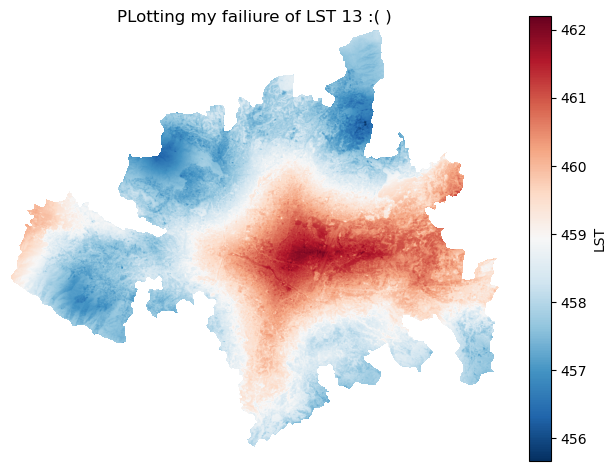

In [37]:
import matplotlib.pyplot as plt
im = plt.imshow(lst13sad, cmap='RdBu_r')
plt.title('PLotting my failiure of LST 13 :( )')

cbar = plt.colorbar(im)
cbar.set_label('LST')

# Hide axes for cleaner look
plt.axis('off')

# Show the plot
plt.tight_layout()
plt.show()

### Understanding NDVI

NDVI is the vegetation index calculation from satelite data. It tells us the proportion of land that is currently occupied by vegetation. Let us compare NDVI stats from 2013 and 2023 to understand how they have changed over the years.

In [7]:
print("Comparing NDVI Over the Years")
print("-" * 40)
print(f"NDVI13 Mean: {np.nanmean(NDVI13):.4f}")
print(f"NDVI23 Mean: {np.nanmean(NDVI23):.4f}")
print(f"\nNDVI13 Median: {np.nanmedian(NDVI13):.4f}")
print(f"NDVI23 Median: {np.nanmedian(NDVI23):.4f}")
print(f"\nNDVI13 Std Dev: {np.nanstd(NDVI13):.4f}")
print(f"NDVI23 Std Dev: {np.nanstd(NDVI23):.4f}")
print(f"\nNDVI13 Min: {np.nanmin(NDVI13):.4f}")
print(f"NDVI23 Min: {np.nanmin(NDVI23):.4f}")
print(f"\nNDVI13 Max: {np.nanmax(NDVI13):.4f}")
print(f"NDVI23 Max: {np.nanmax(NDVI23):.4f}")

Statistical Comparison NDVI13 vs NDVI23
----------------------------------------
NDVI13 Mean: -0.0361
NDVI23 Mean: -0.0157

NDVI13 Median: -0.0213
NDVI23 Median: 0.0027

NDVI13 Std Dev: 0.0641
NDVI23 Std Dev: 0.0625

NDVI13 Min: -0.2875
NDVI23 Min: -0.2753

NDVI13 Max: 0.1751
NDVI23 Max: 0.1781


Interestingly, the NDVI index states that the valley got greener over the decade with the mean mean NDVI value increasing from -0.0361 in 2013 to -0.0157 in 2023. This is unexpected considering that the city has sprawled further in those years. However, the positive improvements in NDVI are not the same across the city. Next, we attempt to see which areas have changed the most in their vegetation over the years.

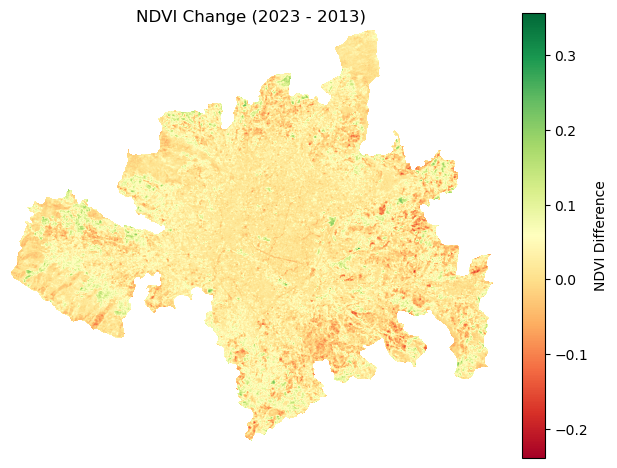

In [10]:
#calculating Difference

NDVI_diff = NDVI23 - NDVI13

im = plt.imshow(NDVI_diff, cmap='RdYlGn')
plt.title('NDVI Change (2023 - 2013)')

# Add colorbar
cbar = plt.colorbar(im)
cbar.set_label('NDVI Difference')
plt.axis('off')

# Show the plot
plt.tight_layout()
plt.show()

We see from the amp that areas in South-East of Kathmandu, in the rural Bhaktapur district has seen the most loss of vegetation. By combining this data with the spatial polygons, we can examine the trends further.

In [41]:
from rasterstats import zonal_stats

NDVI_diff= np.where(np.isnan(NDVI_diff), -9999, NDVI_diff)
stats = zonal_stats(
    main_city,  
    NDVI_diff,
    affine=landsat23.transform,  
    stats=['min', 'max', 'mean', 'median', 'majority'],
    nodata=-9999,
)

mean_stats = [stats_dict["mean"] for stats_dict in stats]
main_city["Avg NDVI Change"] = mean_stats


From the map, we can see that the highest increase in vegetation has happened along the North West and South araes of the city—areas that correspond to national parks that have recieved a lot of greening funding. Comparitively, wards in the South West parts of the city, in rapidly urbanising Bhaktapur, are experiencing the most loss in greenery.

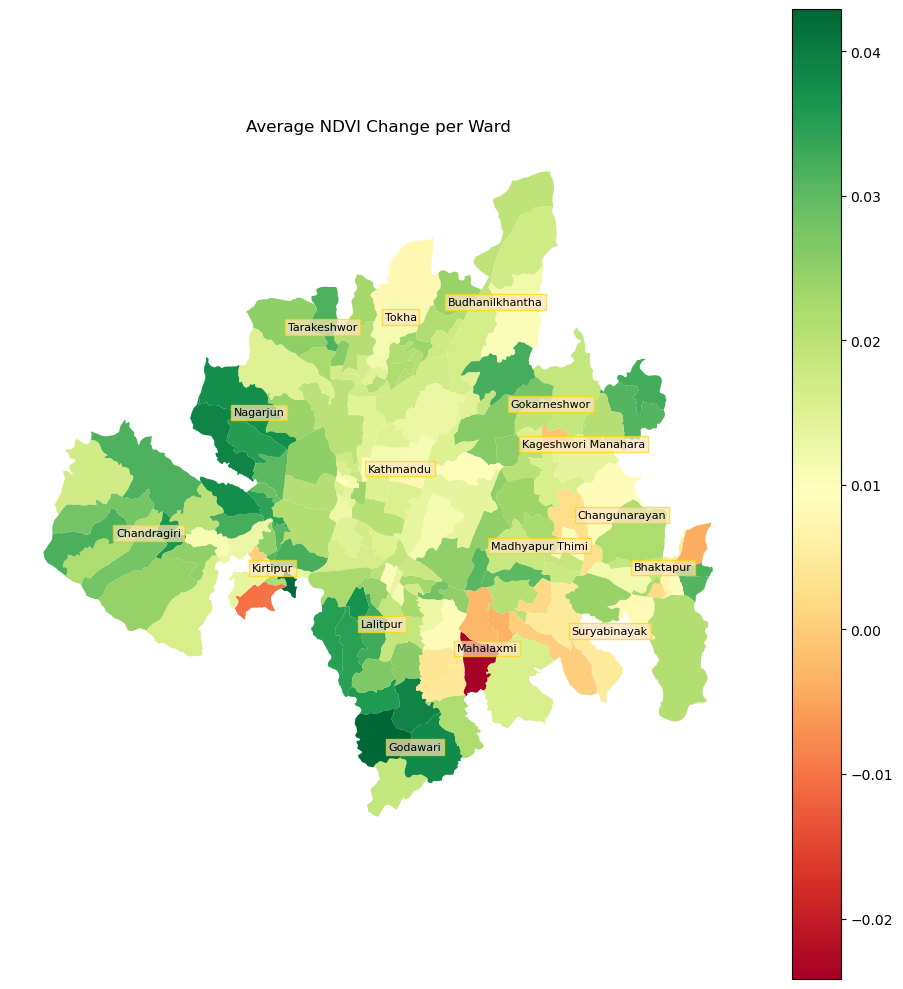

In [35]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

main_city.plot(column='Avg NDVI Change', cmap='RdYlGn', legend=True, ax=ax)

mun_city = main_city.dissolve(by='Municipality_y')

for idx, row in mun_city.iterrows():
    centroid = row.geometry.centroid
    ax.annotate(text=idx, 
                xy=(centroid.x, centroid.y),
                bbox=dict(
                  facecolor='bisque',
                  edgecolor='gold',
                  alpha=0.7,
                  pad=2
                  ),
                horizontalalignment='center',
                fontsize=8)

plt.title('Average NDVI Change per Ward')
plt.tight_layout()
plt.axis('off')
plt.show()

Interestingly, los sof greenery has happened in areas that have the highest estimated income. This indicates that it is higher income households that are moving to the outskirts of the city, contributing to loss in greenery. This along with our analysis in previous part seems to confirm—Kathmandu is susburbanizing.

In [51]:
import altair as alt

alt.Chart(main_city).mark_geoshape(
    stroke='white',
    strokeWidth=0.5
).encode(
    color=alt.Color('Avg NDVI Change', 
        scale=alt.Scale(scheme='redyellowgreen'),
        title='NDVI Change'),
    tooltip=['Mun_Name:N', 'ward:N','Est Income:Q']
).properties(
    width=800,
    height=600,
    title='Loss of Greenery in High Income Areas'
)

alt.Chart(...)